# USGS Water - Ohio Sites
Python source code for getting instantaneous water data from USGS, making transformations, and storing the data for further analysis.

**TODO:**  
* Write export function for writing notebook chunks to src.py

In [4]:
import sys
# !pip install git+https://github.com/SciTools/cartopy.git

  Cloning https://github.com/SciTools/cartopy.git to /tmp/pip-req-build-g06_ac89
  Running command git clone -q https://github.com/SciTools/cartopy.git /tmp/pip-req-build-g06_ac89
  Created wheel for Cartopy: filename=Cartopy-0.18.1.dev125+gd12c86c-cp37-cp37m-linux_x86_64.whl size=12460670 sha256=2c0eb7e9150ca693202491f0cf0c56d00c929887ead3d4f09a3f5ac944d78c1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yhoz5l_c/wheels/92/c1/a5/feb2950e144c80a5d4bc662e62ad79979bd45a195acfc735cc
Successfully built Cartopy
You should consider upgrading via the '/home/mark/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [5]:
# Sys
import os
import json

# Data basics
import pandas as pd
import numpy as np
import datetime

# API requests
import urllib.parse
import requests

# Maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#### Get most recent data from all Ohio sites

In [39]:
url = 'https://waterservices.usgs.gov/nwis/iv/?format=json&stateCd=oh&parameterCd=00060&siteStatus=all&modifiedSince=PT1H'
headers = {'Accept-Encoding': 'gzip'}
df_json = requests.get(url, headers=headers).json()

#### Convert to a pandas DataFrame

In [40]:
df_pd = pd.DataFrame({
    "site_name": [x['sourceInfo']['siteName'] for x in df_json['value']['timeSeries']],
    "site_cd": [x['sourceInfo']['siteCode'][0]['value'] for x in df_json['value']['timeSeries']],
    "time_zn_offset": [x['sourceInfo']['timeZoneInfo']['defaultTimeZone']['zoneOffset'] for x in df_json['value']['timeSeries']],
    "time_zn": [x['sourceInfo']['timeZoneInfo']['defaultTimeZone']['zoneAbbreviation'] for x in df_json['value']['timeSeries']],
    "geo_srs": [x['sourceInfo']['geoLocation']['geogLocation']['srs'] for x in df_json['value']['timeSeries']],
    "geo_lat": [x['sourceInfo']['geoLocation']['geogLocation']['latitude'] for x in df_json['value']['timeSeries']],
    "geo_lon": [x['sourceInfo']['geoLocation']['geogLocation']['longitude'] for x in df_json['value']['timeSeries']],
    "var_cd": [x['variable']['variableCode'][0]['value'] for x in df_json['value']['timeSeries']],
    "var_name": [x['variable']['variableName'] for x in df_json['value']['timeSeries']],
    "var_desc": [x['variable']['variableDescription'] for x in df_json['value']['timeSeries']],
    "var_type": [x['variable']['valueType'] for x in df_json['value']['timeSeries']],
    "var_unit": [x['variable']['unit']['unitCode'] for x in df_json['value']['timeSeries']],
    "var_oid": [x['variable']['oid'] for x in df_json['value']['timeSeries']],
    "value": [x['values'][0]['value'][0]['value'] for x in df_json['value']['timeSeries']],
    "value_dt": [x['values'][0]['value'][0]['dateTime'] for x in df_json['value']['timeSeries']],
    "name": [x['name'] for x in df_json['value']['timeSeries']]
})

#### Quick look
##### Site Info

In [41]:
df_pd.shape

(225, 16)

In [42]:
df_pd.head()

,site_name,site_cd,time_zn_offset,time_zn,geo_srs,geo_lat,geo_lon,var_cd,var_name,var_desc,var_type,var_unit,var_oid,value,value_dt,name
0,Mahoning River bl Berlin Dam nr Berlin Center OH,03090500,-05:00,EST,EPSG:4326,41.048391,-81.001203,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,157,2020-10-30T21:15:00.000-04:00,USGS:03090500:00060:00000
1,Mahoning River at Pricetown OH,03091500,-05:00,EST,EPSG:4326,41.131446,-80.971202,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,191,2020-10-30T22:00:00.000-04:00,USGS:03091500:00060:00000
2,West Branch Mahoning River at Wayland OH,03092460,-05:00,EST,EPSG:4326,41.157001,-81.071762,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,72.6,2020-10-30T21:15:00.000-04:00,USGS:03092460:00060:00000
3,Eagle Creek at Phalanx Station OH,03093000,-05:00,EST,EPSG:4326,41.261167,-80.954257,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,1210,2020-10-30T22:00:00.000-04:00,USGS:03093000:00060:00000
4,Mahoning River at Leavittsburg OH,03094000,-05:00,EST,EPSG:4326,41.239223,-80.880642,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,2810,2020-10-30T21:15:00.000-04:00,USGS:03094000:00060:00000


In [43]:
df_pd.describe(include="all")

,site_name,site_cd,time_zn_offset,time_zn,geo_srs,geo_lat,geo_lon,var_cd,var_name,var_desc,var_type,var_unit,var_oid,value,value_dt,name
count,225,225,225,225,225,225.000000,225.000000,225,225,225,225,225,225,225,225,225
unique,225,225,1,1,1,NaN,NaN,1,1,1,1,1,1,207,16,225
top,Flume at SR 30 E of Apple Creek nr Wooster OH,03246500,-05:00,EST,EPSG:4326,NaN,NaN,00060,"Streamflow, ft&#179;/s","Discharge, cubic feet per second",Derived Value,ft3/s,45807197,0.00000,2020-10-30T21:30:00.000-04:00,USGS:03234500:00060:00000
freq,1,1,225,225,225,NaN,NaN,225,225,225,225,225,225,11,55,1
mean,NaN,NaN,NaN,NaN,NaN,40.510479,-82.739541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,0.766705,1.200791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,38.532056,-84.801626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,39.951173,-83.882306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,40.571944,-82.821290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,41.237549,-81.609010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
pd.DataFrame({
    "datatype": df_pd.dtypes
})

,datatype
site_name,object
site_cd,object
time_zn_offset,object
time_zn,object
geo_srs,object
geo_lat,float64
geo_lon,float64
var_cd,object
var_name,object
var_desc,object


In [45]:
# Get our min & max latitude and longitudes
max_lon = df_pd['geo_lon'].max()
min_lon = df_pd['geo_lon'].min()

max_lat = df_pd['geo_lat'].max()
min_lat = df_pd['geo_lat'].min()

height = max_lat - min_lat
width = max_lon - min_lon


lon = df_pd['geo_lon'].to_numpy()
lat = df_pd['geo_lat'].to_numpy()

##### Get a recent Landsat 8 image of Ohio

In [46]:
# api_key = 'rOidbPDztcgJNb96POmqExLQOIJgNXPD7bXULDLe'

In [47]:
# date_start = datetime.date.today() - datetime.timedelta(days=60)

# url = 'https://api.nasa.gov/planetary/earth/assets?lat={}&lon={}&date={}&dim={}&api_key={}'.format(
#     str(round(min_lat + (height / 2), 2)),
#     str(round(min_lon + (width / 2), 2)),
#     str(date_start),
#     str(0.6),
#     api_key
# )
# asset = requests.get(url)
# asset.json()

In [18]:
# with open('ohio_sat.png', 'wb') as handle:
#     img_data = requests.get(asset.json()['url']).content
#     handle.write(img_data)

In [48]:
# date = str(datetime.date.today())
# api_key = 'rOidbPDztcgJNb96POmqExLQOIJgNXPD7bXULDLe'

# url = 'https://api.nasa.gov/planetary/earth/imagery?lon={}&lat={}&dim={}&api_key={}'.format(
#     str(round(min_lon + (width / 2), 2)),
#     str(round(min_lat + (height / 2), 2)),
#     str(10),
#     api_key
# )
# print(url)

In [49]:
# r = requests.get(url)

##### Show the locations of Ohio Water Sites

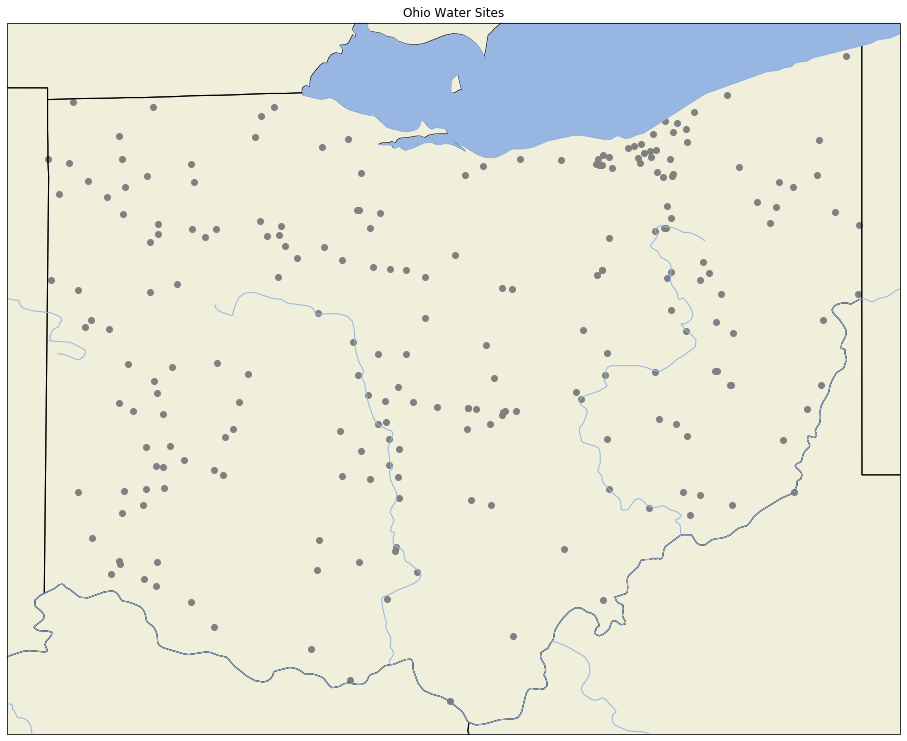

In [51]:
fig = plt.figure(figsize=(16, 16))

img_extent = (min_lon, max_lon, min_lat, max_lat)
img = plt.imread(im_path)

ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Ohio Water Sites')

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

plt.scatter(
    lon,
    lat,
    color='gray'
)

plt.show()